# DistillBERT Pre-trained Model

## Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

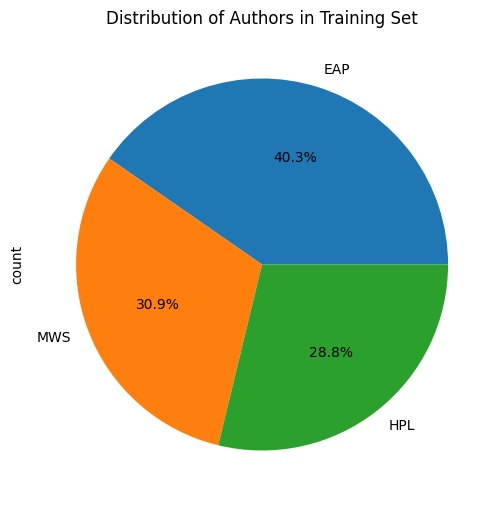

In [16]:
df = pd.read_csv("./train/train.csv")
plt.figure(figsize=(6, 7))
df['author'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Distribution of Authors in Training Set")
plt.show()

## DistilBERT Pipeline and Import

In [17]:
import torch
from transformers import pipeline
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

classifier = pipeline(
    task="text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    dtype=torch.float16,
    device=0 if torch.cuda.is_available() else -1,
)

result = classifier("I love using Hugging Face Transformers!")
print(result)
# Output: [{'label': 'POSITIVE', 'score': 0.9998}]

CUDA is available. Using GPU: NVIDIA GeForce RTX 3070


Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9971327781677246}]


In [18]:
from transformers import DistilBertConfig, DistilBertModel

# Initializing a DistilBERT configuration
configuration = DistilBertConfig()

# Initializing a model (with random weights) from the configuration
model = DistilBertModel(configuration)

# Accessing the model configuration
configuration = model.config

In [19]:
# DistilBERT tokenization, dataset prep, Trainer pipeline
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from datasets import Dataset
from transformers import pipeline
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer

# map authors to integer labels (stable ordering)
authors = sorted(df['author'].unique())
label_map = {a:i for i,a in enumerate(authors)}
df['label'] = df['author'].map(label_map)

# small train/validation split (stratified)
train_df, val_df = train_test_split(df[['text','label']], test_size=0.1, stratify=df['label'], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Convert to Hugging Face Dataset objects
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

# Tokenizer (fast) - will download from Hugging Face if not cached
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_batch(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=256)

# Tokenize datasets (batched)
train_ds = train_ds.map(tokenize_batch, batched=True)
val_ds = val_ds.map(tokenize_batch, batched=True)

# Set format for PyTorch Trainer
cols = ['input_ids','attention_mask','label']
train_ds.set_format(type='torch', columns=cols)
val_ds.set_format(type='torch', columns=cols)

# Initialize model for sequence classification
num_labels = len(label_map)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels, dropout=0.2, attention_dropout=0.2)

# Metrics function
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Training arguments - adjust epochs / batch sizes as needed
training_args = TrainingArguments(
    output_dir='./distilbert-author-classifier',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

# To start training, uncomment the following line (requires GPU for speed):
trainer.train()

# After training save the model and tokenizer:
trainer.save_model('./distilbert-author-classifier')
tokenizer.save_pretrained('./distilbert-author-classifier')

# Quick inference example (works after saving or you can use 'model' directly):
device = 0 if torch.cuda.is_available() else -1

# Load saved model path
model_path = './distilbert-author-classifier'
classifier = pipeline('text-classification', model=model_path, tokenizer=tokenizer, device=device)

# Label mapping (for reference):
print(label_map)

Map: 100%|██████████| 1958/1958 [00:00<00:00, 10658.95 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.492000,0.457660,0.824821,0.825004
2,0.393200,0.425128,0.836568,0.837014
3,0.266400,0.441183,0.842186,0.842947
4,0.242400,0.407414,0.858018,0.858081
5,0.214600,0.434422,0.855465,0.855626


Device set to use cuda:0


{'EAP': 0, 'HPL': 1, 'MWS': 2}


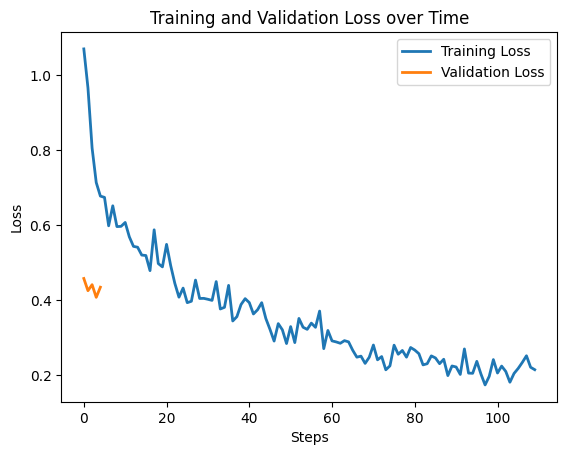

In [20]:
# Plot Losses Based on Steps not Epochs
train_losses =trainer.state.log_history
train_loss_values = [x['loss'] for x in train_losses if 'loss' in x]
eval_loss_values = [x['eval_loss'] for x in train_losses if 'eval_loss' in x]


plt.plot(train_loss_values, label='Training Loss', linewidth=2)
plt.plot(eval_loss_values, label='Validation Loss', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

## Load Trained DistilBERT

In [21]:
# Load saved model
model_path = './distilbert-author-classifier'
model = DistilBertForSequenceClassification.from_pretrained(model_path)

## Testing / Evaluation

In [22]:
test_df = pd.read_csv('./test/test.csv')
test_ds = Dataset.from_pandas(test_df)
test_ds = test_ds.map(tokenize_batch, batched=True)

preds = trainer.predict(test_ds)
test_preds = np.argmax(preds.predictions, axis=1)

Map: 100%|██████████| 8392/8392 [00:00<00:00, 10374.58 examples/s]


In [23]:
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id']
submission_df['EAP'] = 0
submission_df['HPL'] = 0
submission_df['MWS'] = 0

for i, pred in enumerate(test_preds):
    if pred == 0:
        submission_df.at[i, 'EAP'] = 1
    elif pred == 1:
        submission_df.at[i, 'HPL'] = 1
    elif pred == 2:
        submission_df.at[i, 'MWS'] = 1

submission_df.to_csv('distilbert_submission.csv', index=False)